In [1]:
from SimPEG import *
from simpegEM1D import EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, set_mesh_1d
import numpy as np
%pylab inline
import empymod
from simpegEM1D import skytem_HM_2015, skytem_LM_2015
wave = skytem_LM_2015()
# LM
tind = 3
time_input_currents = wave.current_times[-13:]
input_currents = wave.currents[-13:]
# time = wave.time_gate_center
time = np.logspace(-5, -3, 21)
hz = get_vertical_discretization_time(time, facter_tmax=0.5, factor_tmin=10.)

mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC

Populating the interactive namespace from numpy and matplotlib


In [8]:
print(input_currents)

[0.        0.10078   0.45234   0.76328   1.        1.        0.86353
 0.34002   0.11033   0.044709  0.013388  0.0044389 0.       ]


In [9]:
print(time_input_currents)

[-8.0000e-04 -7.2902e-04 -4.0497e-04 -1.5238e-04 -1.0000e-06  0.0000e+00
  1.1535e-06  3.0943e-06  4.7797e-06  6.1076e-06  7.7420e-06  9.0699e-06
  9.4274e-06]


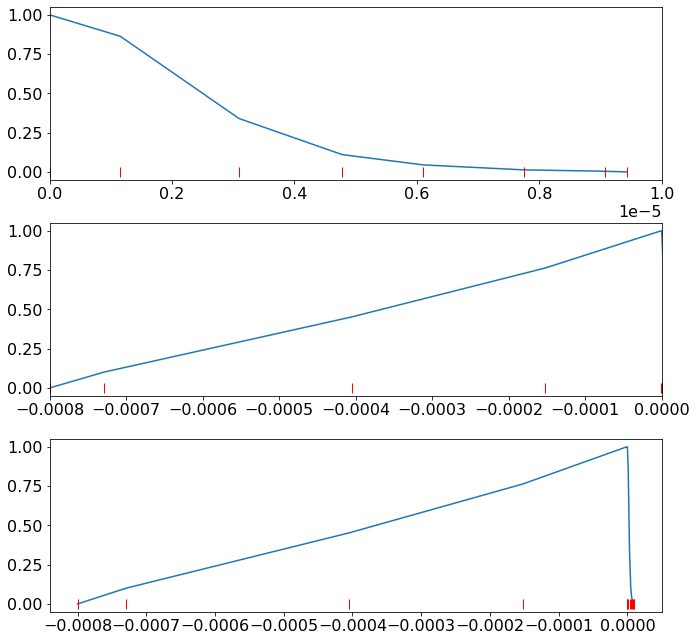

In [10]:
fig,ax = plt.subplots(3,1,figsize=(10,10))
ax[0].plot(time_input_currents, input_currents,label='ramp off')
ax[0].plot(time_input_currents, np.zeros(len(time_input_currents)), 'r|', ms=10)
#ax.plot(time_channels,0.1*np.ones(len(time_channels)),'*',label='time channels')
ax[0].set_xlim([0,10e-6])

ax[1].plot(time_input_currents, input_currents,label='ramp on')
ax[1].plot(time_input_currents, np.zeros(len(time_input_currents)), 'r|', ms=10)
#ax.plot(time_channels,0.1*np.ones(len(time_channels)),'*',label='time channels')
ax[1].set_xlim([-8e-4,0])


ax[2].plot(time_input_currents, input_currents,label='all wave')
ax[2].plot(time_input_currents, np.zeros(len(time_input_currents)), 'r|', ms=10)
#ax.plot(time_channels,0.1*np.ones(len(time_channels)),'*',label='time channels')
#ax[2].set_xlim([-8e-4,0])


plt.rcParams.update({'font.size': 16})

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

In [1]:
# time_input_currents = wave.current_times[-7:]
# input_currents = wave.currents[-7:]

TDsurvey = EM1DSurveyTD(
    rx_location = np.array([0., 0., 100.+30.]),
    src_location = np.array([0., 0., 100.+30.]),
    topo = np.r_[0., 0., 100.],
    depth = depth,
    rx_type = 'dBzdt',
    wave_type = 'general',
    src_type = 'CircularLoop',
    a = 13.,
    I = 1.,
    time = time,
    time_input_currents=time_input_currents,
    input_currents=input_currents,
    n_pulse = 2,
    base_frequency = 210.,
    use_lowpass_filter=False,
    high_cut_frequency=1e5
)

sig_half = 1e-2
sig_blk = 5e-1
chi_half = 0.
wires = Maps.Wires(('sigma', mesh1D.nC),('h', 1))
expmap = Maps.ExpMap(mesh1D)
sigmaMap = expmap * wires.sigma

sig  = np.ones(TDsurvey.n_layer)*sig_half
blk_ind = (-30>LocSigZ) & (-50<LocSigZ)
sig[blk_ind] = sig_blk
m_true = np.r_[np.log(sig), TDsurvey.h]
m_true_dh = np.r_[np.log(sig), TDsurvey.h-5.]
dh = 0.01
m_dx_p = np.r_[np.log(sig), TDsurvey.h+dh/2]
m_dx_n = np.r_[np.log(sig), TDsurvey.h-dh/2]

prob = EM1D(mesh1D, sigmaMap=sigmaMap, hMap=wires.h)
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
prob.chi = np.zeros(TDsurvey.n_layer)
d_true = TDsurvey.dpred(m_true)
d_true_dh = TDsurvey.dpred(m_true_dh)
d_p = TDsurvey.dpred(m_dx_p)
d_n = TDsurvey.dpred(m_dx_n)

np.random.seed(1)
TDsurvey.dtrue = d_true
std = 0.05
noise = std*abs(TDsurvey.dtrue)*np.random.randn(TDsurvey.dtrue.shape[0])
floor = 0.
std = 0.05
TDsurvey.dobs = TDsurvey.dtrue+noise
uncert = abs(TDsurvey.dobs)*std+floor

Populating the interactive namespace from numpy and matplotlib


In [2]:
prob.getJ_height(m_true).shape

(21, 1)

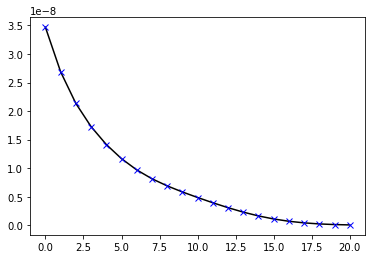

In [3]:
J_h_diff = (d_p-d_n) / (dh)
plt.plot(J_h_diff, 'k')
plt.plot(prob.getJ_height(m_true), 'bx')

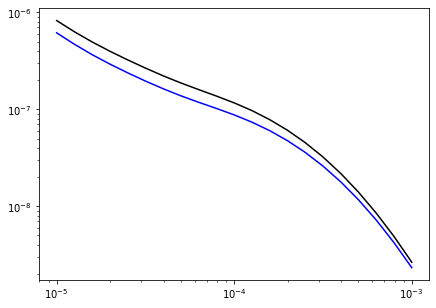

In [4]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -d_true, 'b-')
axes.plot(TDsurvey.time, -d_true_dh, 'k-')
# axes.plot(TDsurvey.time, -TDsurvey.dobs, 'r.-')
axes.set_xscale('log');
axes.set_yscale('log');

In [5]:
dmisfit = DataMisfit.l2_DataMisfit(TDsurvey)
dmisfit.W = 1./(abs(TDsurvey.dobs)*std+floor)

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [6]:
m0 = np.r_[np.log(np.ones_like(sig)*sig_half), 29.]
reg_sigma = Regularization.Sparse(
    mesh1D, mapping=wires.sigma
)
p=0.
qx, qz = 2., 2.
reg_sigma.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=20, minGNiter=1, fix_Jmatrix=True, coolingRate=2, 
    betaSearch=False,
    chifact_start = 1.5
)
mesh_h = Mesh.TensorMesh([1])
reg_h = Regularization.Sparse(
    mesh_h, mapping=wires.h, 
    alpha_s = 1.
)
reg = reg_sigma + reg_h
opt = Optimization.ProjectedGNCG(maxIter = 30)
opt.maxIterLS = 5
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=2)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit()
update_sense = Directives.UpdateSensitivityWeights()
# inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,betaest])

prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

C:\ProgramData\Anaconda3\envs\em1d\lib\site-packages\SimPEG\Directives.py:934: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  warnings.warn(


In [7]:
%%time
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.59e+01  3.72e+03  0.00e+00  3.72e+03    2.48e+03      0              
   1  1.59e+01  2.08e+03  1.16e+01  2.26e+03    4.61e+02      0              
   2  7.95e+00  1.75e+03  1.95e+01  1.91e+03    2.05e+02      0   Skip BFGS  
   3  7.95e+00  1.34e+03  4.59e+01  1.71e+03    1.59e+02      0              
   4  3.98e+00  9.51e+02  7.06e+01  1.23e+03    3.01e+02      0              
   5  3.98e+00  3.64e+02  1.44e+02  9.35e+02    3.57e+02      0              
   6  1.99e+

In [8]:
opt.counter.summary()
xc = opt.recall('xc')

Counters:
  ProjectedGNCG.activeSet                 :       30
  ProjectedGNCG.doEndIteration            :       29
  ProjectedGNCG.doStartIteration          :       30
  ProjectedGNCG.modifySearchDirectionBreak:        1
  ProjectedGNCG.projection                :      134
  ProjectedGNCG.scaleSearchDirection      :       30

Times:                                        mean      sum
  EM1D.Jtvec_approx                       : 8.24e-04, 1.47e-01,  178x
  EM1D.Jvec_approx                        : 5.47e-03, 9.73e-01,  178x
  ProjectedGNCG.findSearchDirection       : 8.13e-02, 2.44e+00,   30x
  ProjectedGNCG.minimize                  : 1.93e+01, 1.93e+01,    1x
  ProjectedGNCG.modifySearchDirection     : 2.31e-01, 6.93e+00,   30x


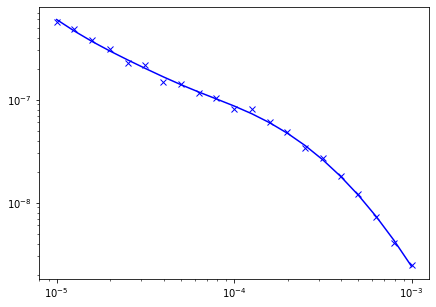

In [9]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -invProb.dpred, 'b-')
axes.plot(TDsurvey.time, -TDsurvey.dobs, 'bx')
axes.set_xscale('log');
axes.set_yscale('log');

In [10]:
print (wires.h*m0)
print (wires.h*mopt)
print (TDsurvey.h)

[29.]
[22.45411635]
30.0


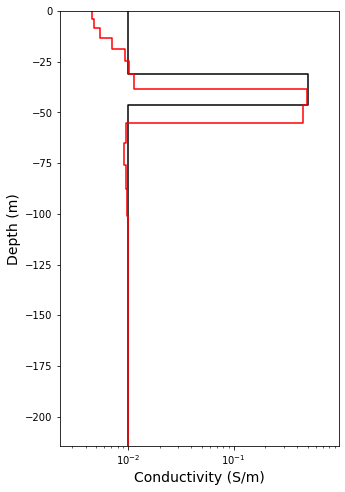

In [11]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, mesh1D)
Utils1D.plotLayer(sigmaMap*mopt, mesh1D, showlayers=False, **{'color':'r'})
# Utils1D.plotLayer(sigmaMap*invProb.l2model, mesh1D, showlayers=False, **{'color':'b', 'lw':1.})

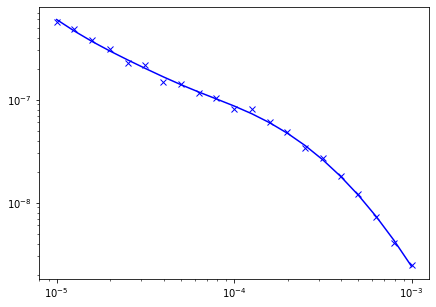

In [12]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -invProb.dpred, 'b-')
axes.plot(TDsurvey.time, -TDsurvey.dobs, 'bx')
axes.set_xscale('log');
axes.set_yscale('log');

In [13]:
EM1D.Jvec_approx

<function SimPEG.Problem.BaseProblem.Jvec_approx(self, m, v, f=None)>

In [ ]:
t0 = time.time()

J = []
for i in range(len(model)):
    ei = np.zeros_like(model)
    ei[i] = 1.0
    J.append(simulation.Jvec(model, ei, f=fields))

J = np.vstack(J)

t1 = time.time()
print("   J {}".format(t1 - t0))